# as you walk in, please run on your terminal:
# pip install seaborn==0.8.1
# https://goo.gl/xLRiEL

# Imports

To complete this assignment we will use the Pandas data analysis library, with the Seaborn library for visualization.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

In [3]:
# lets check that we have the latest version of seaborn so we can use the latest, fanciest tools 
sns.__version__

'0.8.1'

# Loading the data

Before we can start answering questions about the data we need to do a little bit of exploratory analysis. We start by loading the data into memory. 
Pandas comes with a built-in `read_csv` function that we can use to read CSV files.

In [4]:
diagnosis = pd.read_csv('./Patient_Diagnosis.csv')
treatments = pd.read_csv('./Patient_Treatment.csv')

We can now take a look at the data to familiarize ourselves with the format and data types.

In [5]:
diagnosis.head()

,Patient_ID,Diagnosis_Date,Diagnosis_Code,Diagnosis
0,2038,1/21/10,174.9,Breast Cancer
1,2120,1/9/10,174.1,Breast Cancer
2,2175,2/17/10,174.7,Breast Cancer
3,2407,6/13/10,174.9,Breast Cancer
4,2425,12/15/10,174.9,Breast Cancer


In [6]:
treatments.head()

,Patient_ID,Treatment_Date,Drug_Code
0,2038,1/24/10,A
1,2120,1/24/10,A
2,2120,1/24/10,B
3,2120,1/26/10,A
4,2120,1/26/10,B


The first thing we need to do is to check whether there are some obvious sources of noise in the data such as missing values or impossible values due to corruption or typos. This can be easily done by examining the distribution of values in each column, and for clarity and conciseness of the report we omit the code and simply state the conclusion that the dataset is 'clean' and ready for manipulation.

In [7]:
treatments.dtypes

Patient_ID         int64
Treatment_Date    object
Drug_Code         object
dtype: object

In [8]:
diagnosis.dtypes

Patient_ID          int64
Diagnosis_Date     object
Diagnosis_Code    float64
Diagnosis          object
dtype: object

Right away we can see that the dates are being stored as strings. It might be useful to convert them to Datetime objects so that we can perform common arithmetic on them. This will prove useful when calculating duration of treatment and time from diagnosis to treatment.

In [9]:
diagnosis.Diagnosis_Date = pd.to_datetime(diagnosis.Diagnosis_Date)
treatments.Treatment_Date = pd.to_datetime(treatments.Treatment_Date)

In [10]:
diagnosis.dtypes

Patient_ID                 int64
Diagnosis_Date    datetime64[ns]
Diagnosis_Code           float64
Diagnosis                 object
dtype: object

In [11]:
treatments.dtypes

Patient_ID                 int64
Treatment_Date    datetime64[ns]
Drug_Code                 object
dtype: object

In [12]:
# if you have later versions of pandas, you can do df.infer_objects() if you're "FEELING LUCKY!"

We are now ready to start answering questions.

# Question 1: Cancer type breakdown
***"First, the clinic is curious to know for which diseases they are treating patients. How many patients does the clinic have for each cancer type?"***

To answer this question we need to focus our attention on the diagnosis table. The first step is to check whether the number of diagnoses matches the number of patients, since it could be possible for a patient to be diagnosed more than once.

In [13]:
# Number of patients
print(len(diagnosis.Patient_ID.unique()), ' unique patients')
print(len(diagnosis.Patient_ID), ' diagnoses')

# Curveball 
# print(len(diagnosis), ' wait, can i do this too?')

(37, ' unique patients')
(47, ' diagnoses')


So there are 37 unique patients but we have 47 diagnoses, meaning some patients were diagnosed more than once. Let's isolate those cases to gain a better understanding of these multiple diagnoses:

In [14]:
diagnosis.duplicated('Patient_ID', keep=False)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11     True
12     True
13     True
14    False
15     True
16     True
17     True
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25     True
26     True
27     True
28     True
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38     True
39     True
40     True
41     True
42     True
43     True
44     True
45     True
46     True
dtype: bool

In [15]:
# List of patients with multiple diagnosis
# how the duplicated method works: it returns a boolean series denoting all the duplicate rows. 
# keep=False means you keep (set to true) all the dupes, can also pick first / last.
# you can then select exclusively those records out of the dataframe, and sort them.
# (under the hood you are doing a dot product between that boolean series & the dataframe) 

diagnosis[diagnosis.duplicated('Patient_ID', keep=False)].sort_values(['Patient_ID', 'Diagnosis_Date'])

,Patient_ID,Diagnosis_Date,Diagnosis_Code,Diagnosis
11,3449,2011-09-09,153.5,Colon Cancer
42,3449,2011-09-09,153.4,Colon Cancer
13,3757,2011-10-11,174.1,Breast Cancer
12,3757,2011-10-17,153.4,Colon Cancer
43,3757,2011-10-17,153.5,Colon Cancer
15,4256,2011-11-07,174.5,Breast Cancer
44,4256,2011-11-07,174.8,Breast Cancer
16,4354,2012-02-04,174.8,Breast Cancer
45,4354,2012-02-04,174.5,Breast Cancer
17,4374,2012-03-20,174.5,Breast Cancer


**So there are two possible sources of multiple diagnoses:**
* A patient appears twice in the diagnosis table because their particular diagnosis involves multiple codes. An example would be 3449, who is diagnosed with Colon Cancer, specifically a Malignant neoplasm of colon, more precisely cecum (code 153.4) and appendix (code 153.5).
* A patient appears twice in the diagnosis table because he or she was diagnosed with both colon and breast cancer. An example would be patient 7230 who was diagnosed with breast cancer 4 days after being diagnosed with colon cancer.

Back to the question. It would be interesting to see the distribution of patients both at a macro level (colon vs. breast) as well as at a micro level (specific diagnosis code) for each macro type.

In order to do this some data manipulations need to be done. First we combine all diagnoses and diagnosis codes into one field per patient. Then we create an indicator variable for each of the two cancer types, which will be useful for segmenting later. We are now ready to visualize the distribution at the macro level.

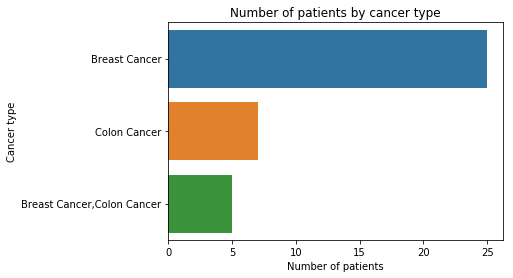

In [18]:
# Make a copy of the diagnosis dataframe
diagnosis_copy = diagnosis.copy()

# Convert diagnosis codes to string, and join them by commas for the same patient
# We don't have to worry about the 'Diagnosis' field since it's already a string
diagnosis_copy.Diagnosis_Code = diagnosis.Diagnosis_Code.apply(str)
unique_codes = diagnosis_copy.groupby(diagnosis_copy.Patient_ID) \
                   .agg(lambda x: ','.join(x.values))

# Remove duplicates from 'Diagnosis' colon ('colon, breast, colon' --> 'colon, breast')
unique_codes.Diagnosis = unique_codes.Diagnosis.str.split(',').\
                                  apply(lambda x: list(set(x))).\
                                  apply(lambda x: ','.join(x))

# Add colon and breast indicator variables
# you can think of unique_codes['Diagnosis'] as being the selectin of a column of a dataframe. 
# The output here is a pandas series, which can be thought of as an indexed vector 
# you can think of the .str method as a helper function that allows you to perform the .contains() method 
# on every element of the vector
unique_codes['breast'] = unique_codes['Diagnosis'].str.contains('Breast')
unique_codes['colon'] = unique_codes['Diagnosis'].str.contains('Colon')

# Plot // countplot show the counts of observations in each categorical bin using bars
sns.countplot(y=unique_codes.Diagnosis)
_ = plt.title('Number of patients by cancer type')
_ = plt.xlabel('Number of patients')
_ = plt.ylabel('Cancer type')

# Question 2: How long after diagnosis do patients start tratment?

**"The clinic wants to know how long it takes for patients to start therapy after being diagnosed, which they consider to be helpful in understanding the quality of care for the patient. How long after being diagnosed do patients start treatment?"**

As with the last question, there are multiple ways we can interpret this question in terms of the different possible combinations and aggregations. We take a general approach, and ignore cancer types and drug types. For patients with multiple diagnoses, the first diagnosis date, and the first treatment date will be considered.

Turning to the `treatments` dataframe, we will sort by patient ID and treatment date, group by patient ID, and keep only the first date.

In [19]:
# Sort treatments by patient ID and Treatment Date
treatments_sorted = treatments.sort_values(['Patient_ID', 'Treatment_Date'])

# Group by Patient ID, select first date, and reset index
first_treatment = treatments_sorted.groupby('Patient_ID').first().reset_index()

**Why reset the index?**

* The index contains data that you want to treat as a column.  {For joining, or for vectorized operations, (Like contains, which we just used above!)}
* The index got messy due to sorting, selecting, or joining.  If you wanted to reset the index to just be increasing, ordered numbers then you would reset and drop the existing one

In [20]:
# View dataframe
first_treatment.head()

,Patient_ID,Treatment_Date,Drug_Code
0,2038,2010-01-24,A
1,2120,2010-01-24,A
2,2175,2010-02-21,A
3,2407,2010-06-19,A
4,2425,2010-12-19,A


Similarly, for the diagnoses, we will keep only the first diagnosis date per patient.

In [21]:
# Sort diagnosis by patient ID and Diagnosis Date
diagnosis_sorted = diagnosis.sort_values(['Patient_ID', 'Diagnosis_Date'])

# Group by Patient ID, select first date, and reset index
first_diagnosis = diagnosis_sorted.groupby('Patient_ID').first().reset_index()

# View dataframe
first_diagnosis.head()

,Patient_ID,Diagnosis_Date,Diagnosis_Code,Diagnosis
0,2038,2010-01-21,174.9,Breast Cancer
1,2120,2010-01-09,174.1,Breast Cancer
2,2175,2010-02-17,174.7,Breast Cancer
3,2407,2010-06-13,174.9,Breast Cancer
4,2425,2010-12-15,174.9,Breast Cancer


We can now merge the two dataframes and look at the difference between diagnosis date and treatment date. We will visualize the distribution with an overlay of boxplot and swarm plot, as well as describe some basic statistics of the time difference.

count                        37
mean     5 days 11:01:37.297297
std      2 days 05:32:40.655400
min             3 days 00:00:00
25%             4 days 00:00:00
50%             5 days 00:00:00
75%             6 days 00:00:00
max            15 days 00:00:00
Name: time_lapse, dtype: object


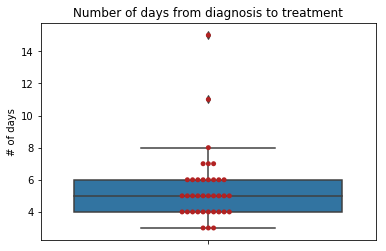

In [24]:
# Merge dataframes
merged_dfs = first_treatment.merge(first_diagnosis, on='Patient_ID')

# Calculate the time difference between diagnosis date and treatment date
merged_dfs['time_lapse'] = merged_dfs['Treatment_Date'].subtract(merged_dfs['Diagnosis_Date'])

# Plot
ax = sns.boxplot(y=merged_dfs['time_lapse'].dt.days)
ax = sns.swarmplot(y = merged_dfs['time_lapse'].dt.days, color='firebrick')
plt.ylabel('# of days')
plt.title('Number of days from diagnosis to treatment')

# Describe
print(merged_dfs['time_lapse'].describe())

**One of the parameters taken by boxplot**

* **whis** : float, optional
* Proportion of the IQR past the low and high quartiles to extend the plot whiskers. 
* Points outside this range will be identified as outliers.

**why are boxplots useful?**

A box plot (or box-and-whisker plot) shows the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range.

We see that, on average, it takes patients five and a half days to start treatment after being diagnosed. There are two outliers, patients for whom treatment started 11 and 15 days after diagnosis. The median is actually just 5 days.


# Question 3: Duration of treatments
**"How do these drugs compare in terms of duration of therapy?"**

There is an easy first stab at this, where you just take the first and last time a drug was administered for a patient and plot that distribution into our favorite: box plots!

In [25]:
# Select first and last treatments by patient and drug code
first_treatments = treatments_sorted.groupby(['Patient_ID', 'Drug_Code']).first()

last_treatments = treatments_sorted.groupby(['Patient_ID', 'Drug_Code']).last()

first_last = first_treatments.join(last_treatments, lsuffix='_start', rsuffix='_end')

# Calculate time difference
first_last['time_elapsed'] = first_last.Treatment_Date_end.subtract(first_last.Treatment_Date_start)

# View dataframe
first_last.head()

Treatment_Date_start Treatment_Date_end time_elapsed
Patient_ID Drug_Code                                                     
2038       A                   2010-01-24         2010-02-20      27 days
           B                   2017-01-24         2017-02-20      27 days
2120       A                   2010-01-24         2010-03-02      37 days
           B                   2010-01-24         2010-03-02      37 days
2175       A                   2010-02-21         2010-04-03      41 days

In [30]:
# Reset index for cleaner code and speedier dataframe
first_last.reset_index(inplace=True)

# when you make a subplot you are making a grid and placing a plot within a spot on that grid
# here you are applying the figure method to a plot object which can be thought of as a canvas. 
# you are setting the size of your canvas, which you can adjust as you see fit
# within the subplot argument, the first two arguments split up your canvas into a matrix. so this canvas
# is a 1 by 2 matrix. the third argument allows you to count the elements within a matrix so that you can place
# your plot into that element. You count elements just like a book
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
sns.boxplot(x=first_last.Drug_Code, y=first_last.time_elapsed.dt.days, showfliers=True)
plt.title('Duration of treatment by drug, with outliers')
plt.xlabel('Drug(s)')
plt.ylabel('Duration of treatment')

plt.subplot(1,2,2)
sns.boxplot(x=first_last.Drug_Code, y=first_last.time_elapsed.dt.days, showfliers=False)
plt.title('Duration of treatment by drug, without outliers')
plt.xlabel('Drug(s)')
_ = plt.ylabel('Duration of treatment')

ValueError: cannot insert level_0, already exists

In order to answer this question more truthfully, though, we have to take into consideration combination therapies. In other words, we must consider the combination of A and B as a separate treatment, to disentangle it from using either A or B alone, which may result in different treatment durations. For that, we will go through the same steps as before to unify all common treatments into one line, this time for all patients. Then grouping by patient ID and Drug Code, and selecting the first and last day will allow us to easily calculate the duration of treatment, which we visualize using boxplots.

In [ ]:
# Unify simultaneous treatments into a single line
all_treatment_combined = treatments_sorted.groupby(['Patient_ID', 'Treatment_Date'])\
                             .agg(lambda x: ','.join(x)).reset_index()


In [ ]:
all_treatment_combined.head(50)

In [ ]:
# Select first and last treatments by patient and drug code
first_treatments = all_treatment_combined.groupby(['Patient_ID', 'Drug_Code']).first()

last_treatments = all_treatment_combined.groupby(['Patient_ID', 'Drug_Code']).last()

# Merge dataframes
first_last = first_treatments.join(last_treatments, lsuffix='_start', rsuffix='_end')

# Calculate time difference
first_last['time_elapsed'] = first_last.Treatment_Date_end.subtract(first_last.Treatment_Date_start)

# View dataframe
first_last.head()

In [ ]:
# Reset index for cleaner code and speedier dataframe
first_last.reset_index(inplace=True)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.boxplot(x=first_last.Drug_Code, y=first_last.time_elapsed.dt.days, showfliers=True)
plt.title('Duration of treatment by drug, with outliers')
plt.xlabel('Drug(s)')
plt.ylabel('Duration of treatment')

plt.subplot(1,2,2)
sns.boxplot(x=first_last.Drug_Code, y=first_last.time_elapsed.dt.days, showfliers=False)
plt.title('Duration of treatment by drug, without outliers')
plt.xlabel('Drug(s)')
_ = plt.ylabel('Duration of treatment')

We chose to visualize both with and without outliers, for added clarity. A detailed description of each of the drug combinations can be found below, but we will outline the results here. The combination of rugs A and B has the shortest average duration, with an average of 54 and a half days. Only using drug B can bring down treatment time to a minimum of 27 days, but as we see from the graph, the standard deviation is very large because there are only 4 patients treated exclusively with B. The median duration of the immunotherapy is 86 days. We do not quote the mean duration here because an outlier, with a treatment duration of more than 500 days, brings the average up.